# Generate low-resolution images

## Setup

In [1]:
# Get ESRGAN-pytorch
! git clone https://github.com/qAp/ESRGAN-pytorch.git
%cd ESRGAN-pytorch/
! git checkout -b distributed remotes/origin/distributed
%cd ../.

Cloning into 'ESRGAN-pytorch'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 889 (delta 15), reused 21 (delta 6), pack-reused 854
Receiving objects: 100% (889/889), 257.20 MiB | 24.30 MiB/s, done.
Resolving deltas: 100% (511/511), done.
/content/ESRGAN-pytorch
Branch 'distributed' set up to track remote branch 'distributed' from 'origin'.
Switched to a new branch 'distributed'
/content


In [1]:
from google.colab import drive
import os, sys, subprocess, shutil
from pathlib import Path
import PIL, cv2, albumentations as A
import numpy as np, scipy.misc
import matplotlib.pyplot as plt
from tqdm import tqdm
sys.path.append('ESRGAN-pytorch')
from ESRGAN_pytorch.datasets.preparation.make_patches import crop_image

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
dir_gdrive = Path('/content/drive/My Drive')

In [4]:
def _cp(src, dst):
    assert src.is_file()
    shutil.copy(src, dst)
    
Path.cp = _cp
Path.ls = lambda o: list(o.iterdir())

## Source images

In [5]:
! cp  /content/drive/My\ Drive/lds-wellington-010m-urban-aerial-photos-2017-JPEG-20200805T075359Z-003.zip .

In [ ]:
! unzip lds-wellington-010m-urban-aerial-photos-2017-JPEG-20200805T075359Z-003.zip

In [7]:
! cp drive/My\ Drive/mixed_big.zip .

In [ ]:
! unzip mixed_big.zip

In [10]:
! cp drive/My\ Drive/tiles_-_singapore_main_sz512.zip .

In [ ]:
! unzip tiles_-_singapore_main_sz512.zip

In [12]:
dir_well = Path('/content/lds-wellington-010m-urban-aerial-photos-2017-JPEG/')
dir_spa = Path('/content/mixed_big/')
dir_sg = Path('/content/tiles_-_singapore_main_sz512/')

In [13]:
len(dir_well.ls()), len(dir_spa.ls()), len(dir_sg.ls())

(442, 909, 2169)

## Downscale Wellington images to ~ Spacenet images

On paper, Wellington images are at 0.1 m resolution, and the Spacenet images are at 0.3 m resolution.

In [14]:
dir_well_lr = Path(f'{dir_well}_LRx3')
dir_well_lr.mkdir(exist_ok=True)
dir_well_lr

PosixPath('/content/lds-wellington-010m-urban-aerial-photos-2017-JPEG_LRx3')

In [15]:
fns_hr = [p for p in dir_well.ls() if p.name.endswith('.jpg')]
for p in tqdm(fns_hr):
    img_hr = PIL.Image.open(p)
    new_size = tuple(int(l / 3) for l in img_hr.size)
    img_lr = img_hr.resize(size=new_size, resample=PIL.Image.BICUBIC)
    img_lr.save(dir_well_lr/p.name)

100%|██████████| 426/426 [02:10<00:00,  3.26it/s]


In [16]:
len(dir_well_lr.ls())

426

These Wellington images at 0.3 m resolution will be treated as the HR images in the ESRGAN training.  Part of the reason that this is done is because the HR tiles are required to be 128x128 in ESRGAN-pytorch.  At 0.1 m resolution, tiles often only show part of a roof, which might not provide enough semantic information.  At 0.3 m resolution, the tiles might contain better semantic information.  

In [17]:
dir_well = dir_well_lr

## Prepare high resolution images

In [18]:
N_WELL, N_SPA, N_SG = 442, 800, 500
SZ_HR, SZ_LR = 128, 32

In [19]:
dir_hrlr = (Path('./')/
            (f'crops_-_'
             f'well_{N_WELL}_'
             f'spa_{N_SPA}_'
             f'sg_{N_SG}_'
             f'bicubic_hr{SZ_HR}_lr{SZ_LR}'))

In [20]:
dir_hr = dir_hrlr/'hr'
dir_hr.mkdir(exist_ok=True, parents=True)

In [21]:
def cp_hr_jpegs(src, dst, num_images=None):
    '''
    Copies all original image files to `dst`, 
    changing file extension to png.
    '''
    src_paths = sorted([n for n in src.ls() 
                        if str(n).endswith(('.jpeg', '.jpg', '.png'))])
    
    if num_images is not None: 
        src_paths = src_paths[:num_images]
        
    for p in tqdm(src_paths): 
        p.cp(dst/f'{p.stem}.png')

In [22]:
for p in dir_hr.ls(): p.unlink()

In [23]:
cp_hr_jpegs(dir_well, dir_hr, num_images=N_WELL)
cp_hr_jpegs(dir_spa, dir_hr, num_images=N_SPA)
cp_hr_jpegs(dir_sg, dir_hr, num_images=N_SG)

100%|██████████| 500/500 [00:00<00:00, 4140.71it/s]


In [24]:
len(dir_hr.ls())

1726

Rename all image files with index number.  Tidier.

In [25]:
format_width = len(str(len(dir_hr.ls())))
format_width

4

In [26]:
for i, p in enumerate(dir_hr.ls()):
    p.replace(p.parent/f'{i:04d}.png')

In [27]:
sorted(dir_hr.ls())[-5:]

[PosixPath('crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/hr/1721.png'),
 PosixPath('crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/hr/1722.png'),
 PosixPath('crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/hr/1723.png'),
 PosixPath('crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/hr/1724.png'),
 PosixPath('crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/hr/1725.png')]

## Downscaling 

In [ ]:
# def scale_image(img, scale=1, resample=PIL.Image.BICUBIC):
#     new_size = tuple(int(scale * l) for l in img.size)
#     return img.resize(size=new_size, resample=resample)

In [ ]:
#Downscale an array by a set factor.
#If an image is 100x100 and the factor is 2, it will be downscaled to 50x50
#Set blur>0 to mimic the PSF of a camera as it moves further away from an object or the surface
#blur= the sigma of a gaussian blur you intend to mimic, we use 1.
#set inter_area==1 to use the more robust and accurate inter area decimation when degrading an image
#Otherwise, uses a bicubic decimation.
def downscale_array(HR_Array,factor=2,blur=0,inter_area=0):
    RasHolder=[]
    #print(HR_Array.shape)
    if blur > 0:
        HR_Array=np.swapaxes(HR_Array,0,2)
        blur_level=(factor/2)*blur
        #print(HR_Array.shape)
        HR_Array = cv2.GaussianBlur(HR_Array, (0, 0), blur_level, blur_level, 0)
        HR_Array=np.swapaxes(HR_Array,2,0)
        #print(HR_Array.shape)
    if inter_area > 0:
        del RasHolder
        #print(HR_Array.shape)
        HR_Array=np.swapaxes(HR_Array,0,2)
        #print(HR_Array.shape)
        #print(factor)
        x=(1/float(factor))
        #print(x)
        RasHolder=cv2.resize(HR_Array, (0,0), fx=x,fy=x, interpolation=cv2.INTER_AREA)
        RasHolder=np.swapaxes(RasHolder,0,2)
    else:
        for i in range(HR_Array.shape[0]):
            HR_band=HR_Array[i]
            HR_Shape=(int(HR_band.shape[0]/factor), int(HR_band.shape[1]/factor))
            HR_Resample=np.array(PIL.Image.fromarray(HR_band).resize(HR_Shape, resample=PIL.Image.BICUBIC))
            # HR_Resample=scipy.misc.imresize(HR_band,HR_Shape,interp='bicubic')
            RasHolder.append(HR_Resample)
        RasHolder=np.asarray(RasHolder)
    return RasHolder

def scale_image(img, **kwargs):
    img = img.transpose((2, 0, 1))
    return downscale_array(img, **kwargs).transpose((1, 2, 0))

In [ ]:
# def scale_image(img, scale=.25, gaussblur=False):
#     h, w = tuple(int(scale * s) for s in img.shape[:2])
#     resize = A.Resize(height=h, width=w, interpolation=cv2.INTER_CUBIC,
#                       always_apply=True)
#     transforms = [resize]
#     if gaussblur:
#         transforms.append(A.GaussianBlur(blur_limit=7, always_apply=True))
#     transforms = A.Compose(transforms)
#     return transforms(image=img)['image']

In [28]:
def scale_image(img, factor=4):
    new_size = tuple(int(s // factor) for s in img.size)
    return img.resize(size=new_size, resample=PIL.Image.BICUBIC)

In [31]:
img = PIL.Image.open(dir_well.ls()[0])
img.size, scale_image(img, factor=1).size

((800, 1200), (800, 1200))

In [32]:
img = PIL.Image.open(dir_hr.ls()[0])
img.size, scale_image(img).size

((650, 650), (162, 162))

### Generate downscaled images

In [33]:
scale_factor = SZ_HR / SZ_LR
scale_factor

4.0

In [34]:
dir_lr = dir_hr.parent/'lr'
dir_lr.mkdir(exist_ok=True, parents=True)

In [35]:
def generate_lr_images(dir_hr, dir_lr, scale_factor=4, **kwargs):
    '''
    For each image in `dir_hr` generate a low-resolution
    version and save it to `dir_lr`.
    '''
    for p in tqdm(dir_hr.ls()):
        hr = PIL.Image.open(p)
        lr = scale_image(hr, factor=scale_factor, **kwargs)
        lr.save(dir_lr/p.name)

In [36]:
for p in dir_lr.ls(): p.unlink()

In [37]:
generate_lr_images(dir_hr, dir_lr, scale_factor=scale_factor)

100%|██████████| 1726/1726 [00:41<00:00, 41.14it/s]


In [38]:
idx = 1110

fn_hr = dir_hr.ls()[idx]
fn_lr = dir_lr/fn_hr.name

PIL.Image.open(fn_hr).size, PIL.Image.open(fn_lr).size

((512, 512), (128, 128))

In [39]:
len(dir_hr.ls()), len(dir_lr.ls())

(1726, 1726)

## Generate image crops

In [40]:
# Stride with which the crop window moves across the original image
STRIDE_HR = 100
stride_lr = int(STRIDE_HR * (SZ_LR / SZ_HR))
SZ_HR, SZ_LR, STRIDE_HR, stride_lr

(128, 32, 100, 25)

In [41]:
%%time
crop_image(dir_hr, SZ_HR, STRIDE_HR)
crop_image(dir_lr, SZ_LR, stride_lr)

[*] [0/1726] Make patch crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/hr/0421.png
[*] [100/1726] Make patch crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/hr/0648.png
[*] [200/1726] Make patch crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/hr/0707.png
[*] [300/1726] Make patch crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/hr/1486.png
[*] [400/1726] Make patch crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/hr/1349.png
[*] [500/1726] Make patch crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/hr/1283.png
[*] [600/1726] Make patch crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/hr/1353.png
[*] [700/1726] Make patch crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/hr/1603.png
[*] [800/1726] Make patch crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/hr/0582.png
[*] [900/1726] Make patch crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/hr/0225.png
[*] [1000/1726] Make patch crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/hr/1251.png
[*] [1100/1726] Make p

In [42]:
len(dir_hr.ls()), len(dir_lr.ls())

(51004, 51004)

In [59]:
idx = 47980

fn_hr = dir_hr.ls()[idx]
fn_lr = dir_lr/fn_hr.name

PIL.Image.open(fn_hr).size, PIL.Image.open(fn_lr).size

((128, 128), (32, 32))

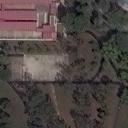

In [60]:
PIL.Image.open(fn_hr)

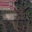

In [61]:
PIL.Image.open(fn_lr)

In [62]:
! du -hs crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/

1.8G	crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/


Copy train HR and LR images to Google Drive for future use.

In [ ]:
! zip -r crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32.zip crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/

In [64]:
! du -hs crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32*

1.8G	crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32
1.6G	crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32.zip


In [65]:
! ls /content/drive/My\ Drive/

 05_esrgan_inference_colab.ipynb
'Colab Notebooks'
 crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32.zip
 esrgan-pytorch_satellite_images.gsheet
 esrgan_results
 JPEG_tiles_Main
 kaggle_-_wheatabox.gsheet
 lds-wellington-010m-urban-aerial-photos-2017-JPEG-20200805T075359Z-003.zip
 mixed_big
 mixed_big.zip
'Official Folder for Engie project'
 omdena_engie
 tiles_-_singapore_main_sz512.zip


In [66]:
! rm -r /content/drive/My\ Drive/crops_-_well_442_spa_800_sg_500_blur1_interarea1_hr128_lr32

rm: cannot remove '/content/drive/My Drive/crops_-_well_442_spa_800_sg_500_blur1_interarea1_hr128_lr32': No such file or directory


In [67]:
! cp crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32.zip /content/drive/My\ Drive/.